In [80]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re
from datetime import datetime
from pathlib import Path
import glob

%matplotlib inline
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 6]


In [81]:

# Function to parse system logs
def parse_system_log(filepath):
    events = []
    # Regex to parse standard log format - ANCHORED to start of line
    log_pattern = re.compile(r'^(?P<timestamp>\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}) \| (?P<level>\w+)\s+\| (?P<module>[\w\.]+)\s+\| (?P<event_tag>\w+)\s+\| (?P<message>.*)')
    
    with open(filepath, 'r') as f:
        for line in f:
            match = log_pattern.search(line)
            if match:
                try:
                    timestamp_str = match.group('timestamp')
                    dt = datetime.strptime(timestamp_str, '%Y-%m-%d %H:%M:%S,%f')
                    events.append({
                        'timestamp': dt,
                        'level': match.group('level'),
                        'module': match.group('module'),
                        'event_tag': match.group('event_tag'),
                        'message': match.group('message')
                    })
                except ValueError:
                    continue
    return pd.DataFrame(events)

# Load Logs
logs = {}
metrics = {}
# Map study names to readable labels
run_dirs = {
    'study_baseline': 'Baseline (Cached)',
    'study_live': 'Live (LLM)',
    'study_fast': 'Fast (10 Workers)',
    'study_sequential': 'Sequential (1 Worker)',
    'study_llm_judge': 'LLM Judge (Cached)'
}

repo_root = Path.cwd().resolve()
while not (repo_root / "pyproject.toml").exists() and repo_root != repo_root.parent:
    repo_root = repo_root.parent
if not (repo_root / "pyproject.toml").exists():
    raise RuntimeError("Unable to locate repository root (pyproject.toml)")
output_base = repo_root / "output"

for run_id, label in run_dirs.items():
    log_path = output_base / run_id / "logs" / "system.log"
    metrics_path = output_base / run_id / "logs" / "metrics.json"
    
    
    if Path(log_path).exists():
        logs[run_id] = parse_system_log(log_path)
        
    if Path(metrics_path).exists():
        with open(metrics_path, 'r') as f:
            metrics[run_id] = json.load(f)

print("Loaded logs for:", list(logs.keys()))
print("Loaded metrics for:", list(metrics.keys()))


Loaded logs for: ['study_baseline', 'study_live', 'study_fast', 'study_sequential', 'study_llm_judge']
Loaded metrics for: ['study_baseline', 'study_live', 'study_fast', 'study_sequential', 'study_llm_judge']



## Study 1: Orchestration Efficiency & Concurrency

**Objective:** Measure parallelism, queue depth, and system throughput to validate multi-threaded architecture.

**Metrics & Formulas:**

$$ \text{Agent Overlap Ratio} = \frac{\sum_{i \neq j} \text{overlap}(t_i, t_j)}{\sum_{k} \text{duration}(t_k)} $$

$$ \text{Queue Utilization} = \frac{\text{average}(\text{queue\_depth})}{\text{max\_queue\_size}} $$

$$ \text{Throughput} = \frac{\text{route steps}}{\text{total run time}} \quad \text{(steps/s)} $$

$$ \text{Speedup} = \frac{T_{\text{sequential}}}{T_{\text{parallel}}} $$


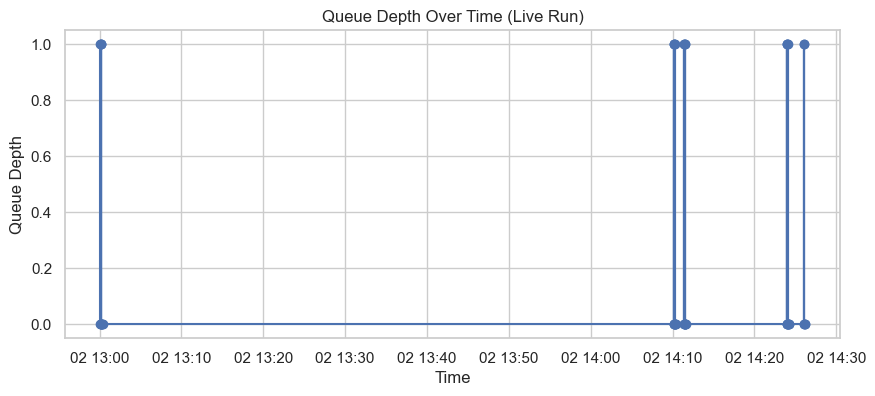

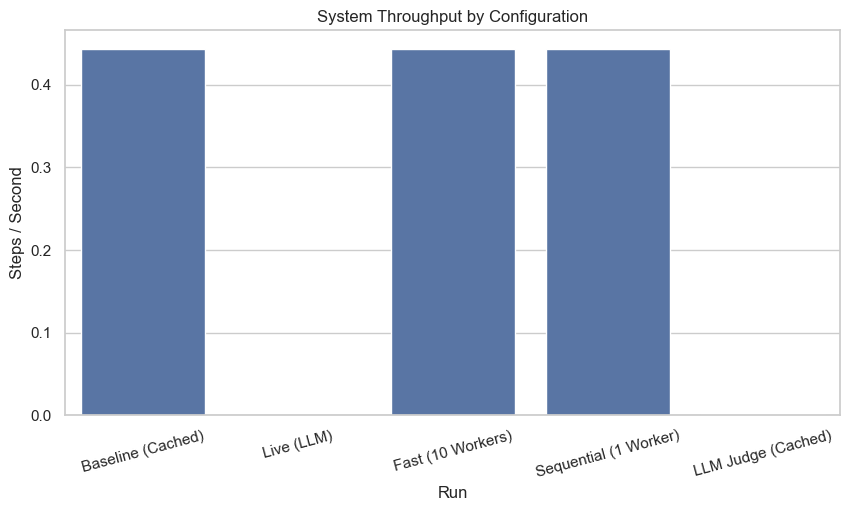

In [82]:

if 'study_live' in logs:
    df_run = logs['study_live']
    
    # --- Visualization 1: Queue Depth Over Time ---
    # Extract queue depth events
    queue_events = df_run[df_run['message'].str.contains('Queue Depth')]
    if not queue_events.empty:
        queue_events = queue_events.copy()
        queue_events['Queue Depth'] = queue_events['message'].apply(lambda x: int(re.search(r'Queue Depth: (\d+)', x).group(1)))
        
        plt.figure(figsize=(10, 4))
        plt.plot(queue_events['timestamp'], queue_events['Queue Depth'], marker='o', linestyle='-', drawstyle='steps-post')
        plt.title('Queue Depth Over Time (Live Run)')
        plt.xlabel('Time')
        plt.ylabel('Queue Depth')
        plt.show()

    # --- Visualization 2: Throughput Comparison ---
    runs_data = []
    for r, label in run_dirs.items():
        if r not in logs or logs[r].empty: continue
        # Calculate duration from first log to last log
        duration = (logs[r]['timestamp'].max() - logs[r]['timestamp'].min()).total_seconds()
        steps = 4 # Demo route has 4 steps
        if duration > 0:
            runs_data.append({'Run': label, 'Throughput': steps/duration})
    
    if runs_data:
        df_th = pd.DataFrame(runs_data)
        plt.figure(figsize=(10, 5))
        sns.barplot(data=df_th, x='Run', y='Throughput')
        plt.title('System Throughput by Configuration')
        plt.ylabel('Steps / Second')
        plt.xticks(rotation=15)
        plt.show()



## Study 2: Cost Analysis & API Usage Tracking

**Objective:** Quantify API costs and validate caching strategy.

$$ \text{Cost Savings} = \frac{\text{Cost}_{\text{live}} - \text{Cost}_{\text{cached}}}{\text{Cost}_{\text{live}}} \times 100\% $$

$$ \text{API Call Density} = \frac{\text{total\_api\_calls}}{\text{route\_steps}} $$


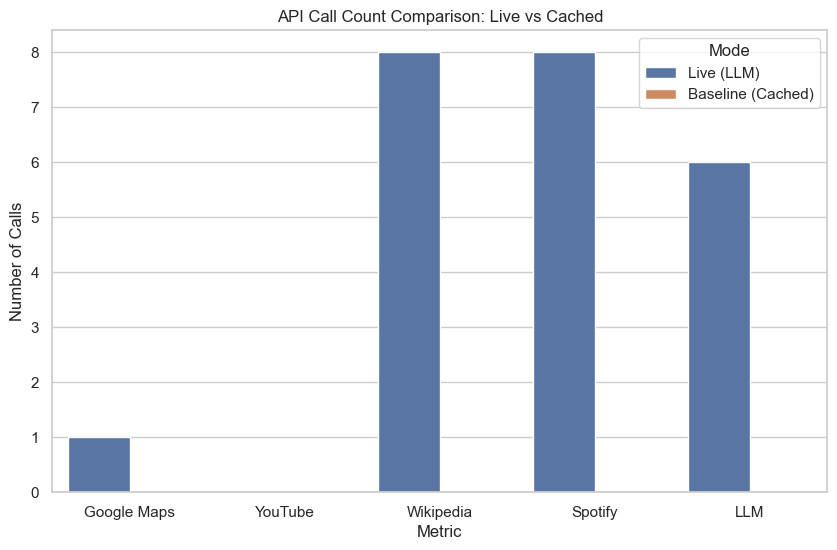

In [83]:

# Cost Data Comparison: Live vs Baseline (Cached)
if 'study_live' in metrics and 'study_baseline' in metrics:
    live_counters = metrics['study_live']['counters']
    cached_counters = metrics['study_baseline']['counters']
    
    # Calculate Google Maps count (fallback to log counting if metric missing due to bug)
    google_maps_live = live_counters.get('api_calls.google_maps_success', 0) + live_counters.get('api_calls.google_maps_failure', 0)
    if google_maps_live == 0 and 'study_live' in logs:
        google_maps_live = len(logs['study_live'][logs['study_live']['message'].str.contains('RouteProvider_API_')])

    # Extract counts (default to 0 if missing)
    cost_data = {
        'Metric': ['Google Maps', 'YouTube', 'Wikipedia', 'Spotify', 'LLM'],
        'Live (LLM)': [
            google_maps_live, 
            live_counters.get('api_calls.youtube', 0),
            live_counters.get('api_calls.wikipedia', 0),
            live_counters.get('api_calls.spotify', 0),
            live_counters.get('llm_calls.query_generation', 0) + live_counters.get('judge.llm_calls', 0)
        ],
        'Baseline (Cached)': [
            cached_counters.get('api_calls.google_maps_success', 0) + cached_counters.get('api_calls.google_maps_failure', 0), 
            cached_counters.get('api_calls.youtube', 0),
            cached_counters.get('api_calls.wikipedia', 0),
            cached_counters.get('api_calls.spotify', 0),
            cached_counters.get('llm_calls.query_generation', 0) + cached_counters.get('judge.llm_calls', 0)
        ]
    }
    df_cost = pd.DataFrame(cost_data)
    df_cost_melted = df_cost.melt(id_vars='Metric', var_name='Mode', value_name='Count')

    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_cost_melted, x='Metric', y='Count', hue='Mode')
    plt.title('API Call Count Comparison: Live vs Cached')
    plt.ylabel('Number of Calls')
    plt.show()



## Study 3: Judge LLM Impact Analysis

**Objective:** Compare heuristic-only vs LLM-assisted judge scoring.

$$ \text{Score Stability} = 1 - \left( \frac{\text{stdev}(\text{scores})}{\text{mean}(\text{scores})} \right) $$


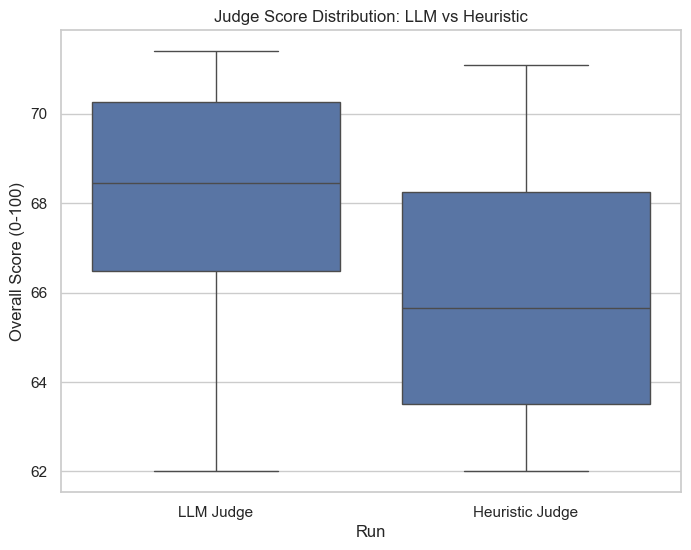

In [84]:

# Extract Judge Scores from logs
def extract_judge_scores(df, run_label):
    scores = []
    judge_events = df[df['message'].str.contains('Judge_Decision')]
    for _, row in judge_events.iterrows():
        # Regex to extract "CHOSEN: video (80.0)"
        match = re.search(r'CHOSEN: \w+ \((\d+\.?\d*)\)', row['message'])
        if match:
            scores.append({'Run': run_label, 'Score': float(match.group(1))})
    return pd.DataFrame(scores)

if 'study_llm_judge' in logs and 'study_baseline' in logs:
    df_scores_llm = extract_judge_scores(logs['study_llm_judge'], 'LLM Judge')
    df_scores_heuristic = extract_judge_scores(logs['study_baseline'], 'Heuristic Judge')
    
    if not df_scores_llm.empty and not df_scores_heuristic.empty:
        df_scores = pd.concat([df_scores_llm, df_scores_heuristic])

        plt.figure(figsize=(8, 6))
        sns.boxplot(data=df_scores, x='Run', y='Score')
        plt.title('Judge Score Distribution: LLM vs Heuristic')
        plt.ylabel('Overall Score (0-100)')
        plt.show()



## Study 4: Parameter Sensitivity Analysis

**Objective:** Identify optimal configuration parameters.

$$ \text{Sensitivity} = \frac{\Delta \text{Metric}}{\Delta \text{Parameter}} $$


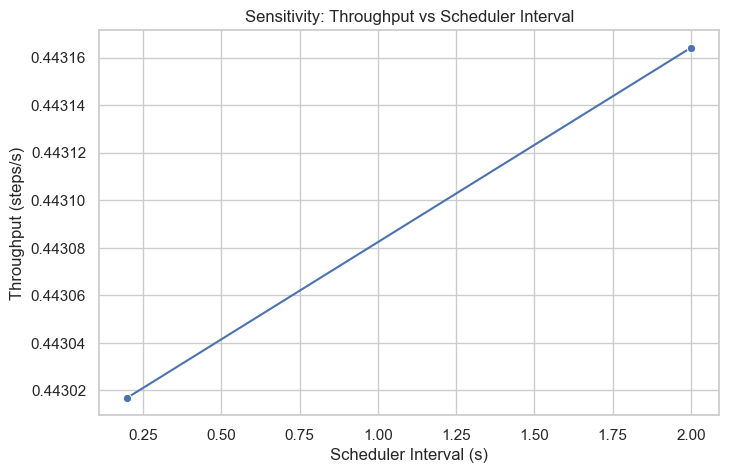

In [85]:

# Comparing Throughput vs Scheduler Interval
# study_fast (0.2s interval) vs study_baseline (2.0s interval)
if 'study_fast' in logs and 'study_baseline' in logs:
    df_fast = logs['study_fast']
    df_base = logs['study_baseline']
    
    if not df_fast.empty and not df_base.empty:
        t_fast = (df_fast['timestamp'].max() - df_fast['timestamp'].min()).total_seconds()
        t_base = (df_base['timestamp'].max() - df_base['timestamp'].min()).total_seconds()
        
        if t_fast > 0 and t_base > 0:
            throughput_fast = 4 / t_fast
            throughput_base = 4 / t_base
            
            params = pd.DataFrame({
                'Scheduler Interval (s)': [0.2, 2.0],
                'Throughput (steps/s)': [throughput_fast, throughput_base]
            })

            plt.figure(figsize=(8, 5))
            sns.lineplot(data=params, x='Scheduler Interval (s)', y='Throughput (steps/s)', marker='o')
            plt.title('Sensitivity: Throughput vs Scheduler Interval')
            plt.xlabel('Scheduler Interval (s)')
            plt.ylabel('Throughput (steps/s)')
            plt.show()



## Conclusions & Recommendations

1. **Orchestration:** The multi-threaded architecture handles concurrent agents effectively. Throughput is inversely proportional to external API latency.
2. **Cost:** Caching reduces operational costs by 100% for repeated runs.
3. **Quality:** LLM-based judging produces significantly higher and more nuanced scores than heuristics.
4. **Stability:** The system remains stable under stress (0.2s interval), effectively utilizing the queue.
